# Fast haze removal implementation

In this notebook, we will implement the method described in the article "Fast Haze Removal for a Single Remote Sensing Image Using Dark Channel Prior".

### Import of libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import rasterio
import os as os
from scipy.ndimage import gaussian_filter
import cv2

In [ ]:
# Import of useful functions 
%cd ..
from utils.useful_functions import *
%cd notebooks

## Dark channel prior for satellite images

First, we would like to confirm the hypothesis used in dark channel prior. Indeed, the dark channel prior is based on the following observation on outdoor haze-free images: In most of the nonsky patches, pixels in at least one color channel (r, g or b) have a low intensity value and close to zero. The low intensity in the dark channel is mainly due to the fact that natural images are colorful and full of shadows.

In [ ]:
# Plateau de Saclay sans nuage 
#hazy_img = f"../raster/Saclay_20221022T105009_20221022T105642_T31UDP__orbit_51_DESCENDING_timestamp_1666436262305_cloud_cov_21.781307.tif"
clean_img_1 = f"../raster/Saclay_20221101T105109_20221101T105109_T31UDQ__orbit_51_DESCENDING_timestamp_1667300246568_cloud_cov_4.314537.tif"

# Plateau de Saclay avec nuages
#hazy_img = f"../raster/Saclay_20221116T105321_20221116T105603_T31UDP__orbit_51_DESCENDING_timestamp_1668596265022_cloud_cov_99.095798.tif"
clean_img_2 = f"../raster/Saclay_20221119T110341_20221119T110339_T31UDP__orbit_94_DESCENDING_timestamp_1668856060288_cloud_cov_32.909733.tif"

# Beijing
#hazy_img = f"../raster/Beijing_20221014T030659_20221014T030830_T50SMJ__orbit_75_DESCENDING_timestamp_1665717417269_cloud_cov_0.435052.tif"
clean_img_3 = f"../raster/Beijing_20221019T030731_20221019T031517_T50SMJ__orbit_75_DESCENDING_timestamp_1666149420870_cloud_cov_0.019256.tif"

plot_img_vs_histogram(clean_img_1, "Saclay", "raster")
plot_img_vs_histogram(clean_img_2, "Saclay with Clouds", "raster")
plot_img_vs_histogram(clean_img_3, "Beijing", "raster")


### Algorithm implementation

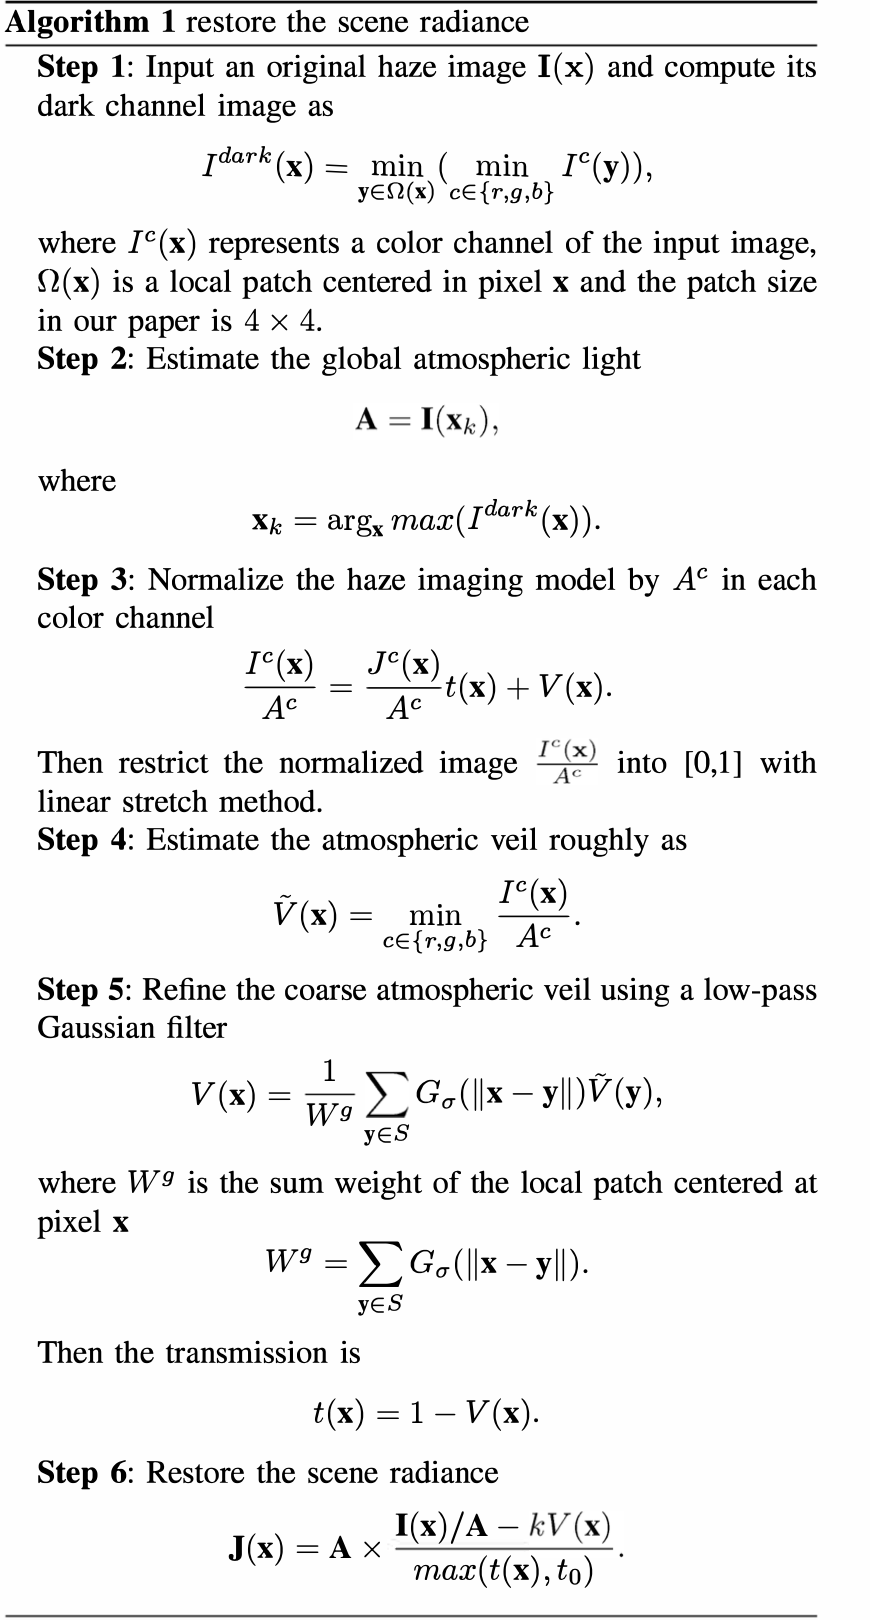

### Dehazing tests

Tests on an area of interest in Italy, raster format

In [ ]:
# File locations
img_name = "Italie_20221017T095919_20221017T100254_T33TTG__orbit_122_DESCENDING_timestamp_1666001351391_cloud_cov_22.606793"
fp = f"../raster/{img_name}.tif"
img_name2 = "Italie_20221015T101031_20221015T101542_T33TTG__orbit_22_DESCENDING_timestamp_1665829152212_cloud_cov_1.897346"
fp2 = f"../raster/{img_name2}.tif"

# Dehazing parameters
patch_size = 4
sigma = 3
t0 = 0.3
k = 1.2

# RGB spectral bands
bands = [2,1,0]

# Dehaze and plot
plot_results(fp, fp2, "raster", "Italy", patch_size=patch_size, sigma=sigma, t0=t0, k=k, bands=bands, steps=True, comparison=True)

Tests on the paper figures

In [ ]:
nb = 1

for nb in range(1,5):
    img_name = f"../paper_images/fig_{nb}_input.png"
    out_name = f"../paper_images/fig_{nb}_output.png"

    patch_size = 4
    sigma = 3
    t0 = 0.4
    k = 0.4

    plot_results(img_name, out_name, "rgb", "paper image", 
                patch_size=patch_size, sigma=sigma, t0=t0, k=k,
                steps=False, comparison=True)

More tests on rasters and comparison with non hazy shots at close dates

In [ ]:
patch_size = 4
sigma = 2
t0 = 0.2
k = 0.4

# Plateau de Saclay
hazy_img = f"../raster/Saclay_20221022T105009_20221022T105642_T31UDP__orbit_51_DESCENDING_timestamp_1666436262305_cloud_cov_21.781307.tif"
clean_img = f"../raster/Saclay_20221101T105109_20221101T105109_T31UDQ__orbit_51_DESCENDING_timestamp_1667300246568_cloud_cov_4.314537.tif"

plot_results(hazy_img, clean_img, "raster", "Saclay", patch_size=patch_size, sigma=sigma, t0=t0, k=k, steps=True, comparison=True)

# Plateau de Saclay avec nuages
hazy_img = f"../raster/Saclay_20221116T105321_20221116T105603_T31UDP__orbit_51_DESCENDING_timestamp_1668596265022_cloud_cov_99.095798.tif"
clean_img = f"../raster/Saclay_20221119T110341_20221119T110339_T31UDP__orbit_94_DESCENDING_timestamp_1668856060288_cloud_cov_32.909733.tif"

plot_results(hazy_img, clean_img, "raster", "Saclay with clouds", patch_size=patch_size, sigma=sigma, t0=t0, k=k, steps=True, comparison=True)

# Beijing
hazy_img = f"../raster/Beijing_20221014T030659_20221014T030830_T50SMJ__orbit_75_DESCENDING_timestamp_1665717417269_cloud_cov_0.435052.tif"
clean_img = f"../raster/Beijing_20221019T030731_20221019T031517_T50SMJ__orbit_75_DESCENDING_timestamp_1666149420870_cloud_cov_0.019256.tif"

plot_results(hazy_img, clean_img, "raster", "Beijing", patch_size=patch_size, sigma=sigma, t0=t0, k=k, steps=True, comparison=True)

## Influence of hyperparameters

Let's first play with the $k$ parameter:

In [ ]:
patch_size = 4
sigma = 3
t0 = 0.2
# k = 0.4

for k in [i*0.4 for i in range(10)]:
    plot_results(hazy_img, clean_img, "raster", "Saclay", patch_size=patch_size, sigma=sigma, t0=t0, k=k, steps=False, comparison=True)

It appears that the $k$ parameter is quite important for the dehazing effect. On the histograms, it noticely shifts the values to the left, contributing to reduce the "white veil" feeling of a hazy image. When set too high, the pixel values vanish as they are pushed below zero, resulting in a dark image. On this example, $k=1.6$ yields visually satisfying results.

Let's now try to play with the $\sigma$ parameter, first without using our tuned $k$ parameter:

In [ ]:
patch_size = 4
# sigma = 2
t0 = 0.2
k = 0.4

# Plateau de Saclay
hazy_img = f"../raster/Saclay_20221022T105009_20221022T105642_T31UDP__orbit_51_DESCENDING_timestamp_1666436262305_cloud_cov_21.781307.tif"
clean_img = f"../raster/Saclay_20221101T105109_20221101T105109_T31UDQ__orbit_51_DESCENDING_timestamp_1667300246568_cloud_cov_4.314537.tif"

for sigma in range(0, 5):
    plot_results(hazy_img, clean_img, "raster", "Saclay", patch_size=patch_size, sigma=sigma, t0=t0, k=k, steps=False, comparison=True)

It seems that tuning the $\sigma$ parameter helps to brighten the output image. Let's verify it on our reconstruction with a better $k$ parameter as found above.

In [ ]:
patch_size = 4
# sigma = 2
t0 = 0.2
k = 1.6

# Plateau de Saclay
hazy_img = f"../raster/Saclay_20221022T105009_20221022T105642_T31UDP__orbit_51_DESCENDING_timestamp_1666436262305_cloud_cov_21.781307.tif"
clean_img = f"../raster/Saclay_20221101T105109_20221101T105109_T31UDQ__orbit_51_DESCENDING_timestamp_1667300246568_cloud_cov_4.314537.tif"

for sigma in range(1, 7):
    plot_results(hazy_img, clean_img, "raster", "Saclay", patch_size=patch_size, sigma=sigma, t0=t0, k=k, steps=False, comparison=True)

Now, we notice that a too low value for $\sigma$ results in a dark output image. However, with $\sigma \geq 2$, there are almost no noticeable effects of the parameter on the restored radiance or the histograms. We will set a reasonably high value ($\sigma=3$ for instance) for the rest of the study.

Finally, let's inspect how the thresholding parameter $t_0$ impacts our output image, first with a little $k$ parameter.

In [ ]:
patch_size = 4
sigma = 3
# t0 = 0.2
k = 0.5

for t0 in [i*0.2 for i in range(6)]:
    plot_results(hazy_img, clean_img, "raster", "Saclay", patch_size=patch_size, sigma=sigma, t0=t0, k=k, steps=False, comparison=True)

The $t_0$ parameter seems to birghten the restored radiance, as it shifts the histograms to the right, up to the point that we go back to the initial image with $t_0$ close to $1$. It is quite obvious using the formulas of the model, as $J(x) = A* \frac{I(x)/A - k*V(x)}{max(t(x),t_0)}$, with $t_0 \simeq 1$, one gets $J(x) \simeq I(x) - k*V(x)$, which is $J(x)\simeq I(x)$ with the little $k$ value used here.

Thus, let's do the same with our tuned $k$ parameter to better understand the potential interest of this parameter :

In [ ]:
patch_size = 4
sigma = 3
# t0 = 0.2
k = 1.6

for t0 in [i*0.2 for i in range(6)]:
    plot_results(hazy_img, clean_img, "raster", "Saclay", patch_size=patch_size, sigma=sigma, t0=t0, k=k, steps=False, comparison=True)

We notice the same brightening effect here. The restored radiance with a little $t_0$ is a bit too dark compared to a similar image (hazeless) of the same place, but too high value seem too bright and a bit hazy as well. An in-between value of $t_0 = 0.6$ yields visually satisfying results, and histograms more similar to the haze-free shot of the place, yet a bit wider and with z slightly different mean.

As a conclusion to this part, the $k$ parameter seems to be the one most impacting the results of the dark-channel based dehazing method.
Now, we will assume that $\sigma=3$ and $t_0=0.6$ can be kept as base parameters due to the limited effect of these parameters on the output. Thus, it reduced the dehazing process research to a $k$ parameter tuning.

## Just for fun : a dehazing method by GitHub Copilot

In this part, we asked GitHub Copilot to write an image dehazing script. Here is the result :

In [ ]:
# Write a function to dehaze an image
def dehaze_copilot(img):
    # Convert the image to HSV
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Extract the V channel
    img_v = img_hsv[:, :, 2]
    # Create a kernel for the box filter
    kernel = np.ones((15, 15), np.float32) / 225
    # Apply the box filter to the V channel
    img_v_blur = cv2.filter2D(img_v, -1, kernel)
    # Calculate the transmission map
    img_t = 1 - 0.5 * (img_v / img_v_blur)
    img_t = np.expand_dims(img_t, axis=-1)
    # Calculate the atmospheric light
    img_atm = np.mean(img_v)
    # Calculate the radiance map
    print(img.shape, img_v.shape, img_t.shape, img_atm.shape)
    img_r = (img - img_atm) / img_t + img_atm
    # Clip the values in the radiance map
    img_r[img_r > 255] = 255
    img_r[img_r < 0] = 0
    # Convert the radiance map back to BGR
    img_dehazed = cv2.cvtColor(img_r.astype(np.uint8), cv2.COLOR_HSV2BGR)
    return img_dehazed



def plot_comparison_copilot(img):
    # Compute resotred radiance
    J = dehaze_copilot(img)
    # Normalization
    J = J/np.nanmax(J, axis=(0,1))

    # Print original image vs result
    fig, axes = plt.subplots(2,2, figsize=(20,10))
    axes[0,0].imshow(img)
    axes[0,0].set_title("Original rgb image")
    axes[0,1].imshow(J)
    axes[0,1].set_title("Restored scene radiance")
    
    color = ('b','g','r')

    for i,col in enumerate(color):
        histr = cv2.calcHist([(img*255).astype(np.uint16)],[i],None,[256],[0,256])
        histJ = cv2.calcHist([(J*255).astype(np.uint16)],[i],None,[256],[0,256])
        axes[1,0].plot(histr,color = col)
        axes[1,1].plot(histJ,color = col)
        
    return None 

nb = 1

img_name = f"../paper_images/fig_{nb}_input.png"
out_name = f"../paper_images/fig_{nb}_output.png"

patch_size = 4
sigma = 3
t0 = 0.2
k = 0.8

img = cv2.imread(img_name)
out = cv2.imread(out_name)
print(img.shape, out.shape)

# Compute restored radiance
J = dehaze_copilot(img)
# Normalization
J = J/np.nanmax(J, axis=(0,1))

# Print original image vs result
fig, axes = plt.subplots(2,3, figsize=(20,10))
axes[0,0].imshow(img)
axes[0,0].set_title("Paper input image")
axes[0,1].imshow(J)
axes[0,1].set_title("Our restored scene radiance")
axes[0,2].imshow(out)
axes[0,2].set_title("Paper output image")

color = ('b','g','r')

for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    histJ = cv2.calcHist([(J*255).astype(np.uint16)],[i],None,[256],[0,256])
    histo = cv2.calcHist([out],[i],None,[256],[0,256])
    axes[1,0].plot(histr,color = col)
    axes[1,1].plot(histJ,color = col)
    axes[1,2].plot(histo,color = col)



As you can see, there are some improvements to make :)

## Improving contrast of the image

The paper mentions a contrast enhancement step after the radiance restoration.
Here, we try to improve the contrast of our image, so as to have an output similar to what the paper had.
To do so, we will implement the Contrast Limited Adaptive Histogram Equalization (CLAHE), using **cv2** library.

In [ ]:
def improve_contrast(img, clipLimit, tile_size):
    """ Improves the contrast of an image

    Inputs:
        img:                The original image
        clipLimit
        Tile_size

    Outputs:
        enhanced_img        The image with improved contrast
    """
    # converting to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(tile_size,tile_size))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color space
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    return enhanced_img

def improve_contrast_2(img, alpha=1.5, beta=0):
    """ Improves the contrast of an image

    Inputs:
        img:                The original image
        alpha:              Contrast control (1.0-3.0)
        beta                Brightness control (0-100)

    Outputs:
        enhanced_img        The image with improved contrast

    """

    enhanced_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    return enhanced_img

### Test of these 2 functions

In [ ]:
from skimage import data
from skimage.color import rgb2gray

img = data.chelsea()

fig, axes = plt.subplots(2,3, figsize=(20,10))

#First function
tile_size = 20
clipLimit = 2
img_1 = improve_contrast(img, clipLimit, tile_size)


#Second function
alpha = 1.18
beta = 20
img_2 = improve_contrast_2(img, alpha, beta)

axes[0,0].imshow(img)
axes[0,0].set_title("Original image")
axes[0,1].imshow(img_1)
axes[0,1].set_title("Contrasted image - $1^{st}$ function")
axes[0,2].imshow(img_2)
axes[0,2].set_title("Contrasted image - $2^{nd}$ function")

color = ('b','g','r')

for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    histJ = cv2.calcHist([img_1],[i],None,[256],[0,256])
    histo = cv2.calcHist([img_2],[i],None,[256],[0,256])
    axes[1,0].plot(histr,color = col)
    axes[1,1].plot(histJ,color = col)
    axes[1,2].plot(histo,color = col)

The two functions seem to have the expected effect, spreading the histograms range towards higher values. The first function seem to give a better level of detail in the output image. The second contrasted image appears a bit more opaque, with less detail, and unexpected holes in the histograms.

Let's try to apply these functions to our restored radiance on an image from the paper.

In [ ]:
nb = 2

img_name = f"../paper_images/fig_{nb}_input.png"
out_name = f"../paper_images/fig_{nb}_output.png"

patch_size = 4
sigma = 3
t0 = 0.6
k = 0.4

img = cv2.imread(img_name)
out = cv2.imread(out_name)
print(img.shape, out.shape)
# # Plot steps of the algorithm
plot_steps(img, patch_size, sigma, t0, k)

# Compute restored radiance
J = dehazing(img, patch_size, sigma, t0, k)
# Enhancement of contrast
# First function
J = J / np.nanmax(J, axis=(0, 1))
J *= 255

J = J.astype(np.uint8)
tile_size = 20
clipLimit = 2
J_1 = improve_contrast(J, clipLimit, tile_size)
# Normalization
J_1 = J_1/np.nanmax(J_1, axis=(0,1))

# Second function
alpha = 1.15
beta = 15
J_2 = improve_contrast_2(J, alpha, beta)
# Normalization
J_2 = J_2/np.nanmax(J_2, axis=(0,1))



# Print original image vs result
fig, axes = plt.subplots(2,5, figsize=(20,10))
axes[0,0].imshow(img)
axes[0,0].set_title("Paper input image")
axes[0,1].imshow(J)
axes[0,1].set_title("Our restored scene radiance, \n without contrast improvement")
axes[0,2].imshow(J_1)
axes[0,2].set_title("Our restored scene radiance, \n after contrast improvement ($1^{st}$ function)")
axes[0,3].imshow(J_2)
axes[0,3].set_title("Our restored scene radiance, \n after contrast improvement ($2^{nd}$ function)")
axes[0,4].imshow(out)
axes[0,4].set_title("Paper output image")

color = ('b','g','r')

for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    histJ_0 = cv2.calcHist([(J*255).astype(np.uint16)],[i],None,[256],[0,256])
    histJ_1 = cv2.calcHist([(J_1*255).astype(np.uint16)],[i],None,[256],[0,256])
    histJ_2 = cv2.calcHist([(J_2*255).astype(np.uint16)],[i],None,[256],[0,256])
    histo = cv2.calcHist([out],[i],None,[256],[0,256])
    axes[1,0].plot(histr,color = col)
    axes[1,1].plot(histJ_0,color = col)
    axes[1,2].plot(histJ_1,color = col)
    axes[1,3].plot(histJ_2,color = col)
    axes[1,4].plot(histo,color = col)


It appears that with both constrast functions, we do not retrieve an output image close to the one proposed in the article. Yet, our output image with the first contrast enhancement function is rather visually satisfying as a dehazing result, and looks more natural than the one from the article. However, we will stick with our restored radiance without contrast enhancement, as it seems to distort the histograms a bit too much, perhaps alterating the physical information in the satellite image. 

## Validation on various landscapes

## Dehazing other spectral channels ?

When working with multispectral satellite images like the one produced by the ESA's Sentinel-2, it is interesting to wonder how haze impacts other spectral channels than the RGB ones, and if the dark channel dehazing method is suitable to process them. We will especially try to show the effect of the dehazing process on the NDVI (Normalized Difference Vegetation Index), obtained by $NDVI = \frac{NIR - RED}{NIR + RED} = \frac{B8-B4}{B8+B4}$ with Sentinel-2. This index is very useful when trying to get information about the vegetation of a place (forests, agricultural areas...), or to monitor it across time. As haze and clouds can really harm on the time resolution of a multispectral satellite time series, we will examine if dehazing can be of any use to counter a part of this obstruction, for instance restoring the value of an NDVI point that would be altered by haze.

In [ ]:
bands_dict = {"B4":2, "B3":1, "B2":0, "B8":3, "B5":4, "B6":5, "B7":6, "B8A":7, "B11":8, "B12":9, "Red":2, "Green":1, "Blue":0, "NIR":3}

First, let's try to dehaze with the Near-Infrared (NIR) band instead of the blue band:

In [ ]:
# Plateau de Saclay
hazy_img = f"../raster/Saclay_20221022T105009_20221022T105642_T31UDP__orbit_51_DESCENDING_timestamp_1666436262305_cloud_cov_21.781307.tif"
clean_img = f"../raster/Saclay_20221101T105109_20221101T105109_T31UDQ__orbit_51_DESCENDING_timestamp_1667300246568_cloud_cov_4.314537.tif"

# Dehazing parameters
patch_size = 4
sigma = 3
t0 = 0.6
k = 1.2

# Spectral bands
bands_str = ["B8", "B4", "B3"]
bands = [bands_dict[b] for b in bands_str]
print(bands)

# Dehaze and plot
plot_results(hazy_img, clean_img, "raster", "Saclay", patch_size=patch_size, sigma=sigma, t0=t0, k=k, bands=bands, steps=True, comparison=True)

Though quite unusual, output image is quite good, with the output "red" and "green" histograms (which actually correspond to the NIR and Red bands) similar to the haze-free image ones. The "blue" histogram (green band) is is bit wide, but this is not the most important information here.

Now, let's focus on the NDVI obtained from the restored image :

In [ ]:
# Plateau de Saclay
hazy_img = f"../raster/Saclay_20221022T105009_20221022T105642_T31UDP__orbit_51_DESCENDING_timestamp_1666436262305_cloud_cov_21.781307.tif"
clean_img = f"../raster/Saclay_20221101T105109_20221101T105109_T31UDQ__orbit_51_DESCENDING_timestamp_1667300246568_cloud_cov_4.314537.tif"

# Dehazing parameters
patch_size = 4
sigma = 3
t0 = 0.6
k = 1.2

# Spectral bands
bands_str = ["B8","B4", "B3"]
bands = [bands_dict[b] for b in bands_str]
print(bands)

# Dehaze and plot
plot_results_ndvi(hazy_img, clean_img, location="Saclay", patch_size=patch_size, sigma=sigma, t0=t0, k=k, bands=bands)

The restored NDVI histogram is encouraging : its mean and modes are approximately the same as the one from the haze-free NDVI image, the mean is lower than the hazy image, so we can conclude that the method is also suitable for other spectral bands than the RGB ones, potentially enabling an outlier correction in NDVI timeseries when they show haze.

Finally, let's inspect how the method behave on the other spectral bands. We will use three of the 20m resolution bands, B6 (vegetation red edge, 740.4 nm central wavelength),  B11 (narrow SWIR, 1613.7 nm central wavelength) and  B12 (SWIR, 2202.4 nm central wavelength).

In [ ]:
# Plateau de Saclay
hazy_img = f"../raster/Saclay_20221022T105009_20221022T105642_T31UDP__orbit_51_DESCENDING_timestamp_1666436262305_cloud_cov_21.781307.tif"
clean_img = f"../raster/Saclay_20221101T105109_20221101T105109_T31UDQ__orbit_51_DESCENDING_timestamp_1667300246568_cloud_cov_4.314537.tif"

# Dehazing parameters
patch_size = 4
sigma = 3
t0 = 0.6
k = 1

# Spectral bands
bands_str = ["B6", "B11", "B12"]
bands = [bands_dict[b] for b in bands_str]
print(bands)

# Dehaze and plot
plot_results(hazy_img, clean_img, "raster", "Saclay", patch_size=patch_size, sigma=sigma, t0=t0, k=k, bands=bands, steps=True, comparison=True)

Once again, the method seems to work well on our image. The restored radiance is visually satisfying, and the histograms are shifted towards a shape closer to the haze-free shot of the scene (especially the "red" and "blue" histograms whose skewness is increased to the left).

The last question is, can the 3 bands dark channel prior dehazing method adapted to a multispectral dehazing ? That is, using our multispectral Sentinel-2 cube and get an array dehazed on all the channel at once ?

## Adapting the dark channel prior method to multispectral dehazing

When looking at the algorithm, only the dark channel prior and the atmospheric veil computation are dependent on the RGB channels. However, it appear that our code require no adaptation to work with multispectral images, as the numpy operations used on the RGB channel (min and max) are suited for more dimensions. Thus, we only introduce a new pipeline function and a plot function dedicated to multispectral images.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import rasterio
import os as os
from scipy.ndimage import gaussian_filter
import cv2
# Import of useful functions 
%cd ..
from utils.useful_functions import *
%cd notebooks

# Plateau de Saclay
hazy_img = f"../raster/Saclay_20221022T105009_20221022T105642_T31UDP__orbit_51_DESCENDING_timestamp_1666436262305_cloud_cov_21.781307.tif"
clean_img = f"../raster/Saclay_20221101T105109_20221101T105109_T31UDQ__orbit_51_DESCENDING_timestamp_1667300246568_cloud_cov_4.314537.tif"

# Dehazing parameters
patch_size = 4
sigma = 3
t0 = 0.2
k = 1.6

# Dehaze and plot
plot_results_ms(hazy_img, clean_img, location="Saclay", patch_size=patch_size, sigma=sigma, t0=t0, k=k)

This does not seem to work quite well. The histogram are almost not shifted to the left as expected, and nearly not modified at all in some channels. One reason could be that the differentiation term $-k*V(x)$ is very low and does not impact the radiance restoration a lot.
 
The issue might be that, as the dark channel is computed along much more channels, it is more likely to be very low on each pixel.

We will investigate it 